In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as py
import os
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline
cmap1 = 'GnBu'
palette1 = 'PuBuGn'

for dirname, _, filenames in os.walk('/content/drive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/case2_submissions.csv
/content/drive/MyDrive/case2_test.csv
/content/drive/MyDrive/case2_train.csv
/content/drive/MyDrive/Bağıl Nem.csv
/content/drive/MyDrive/Radyasyon.csv
/content/drive/MyDrive/Bulutluluk Oranı.csv
/content/drive/MyDrive/Rüzgar Hızı.csv
/content/drive/MyDrive/Rüzgar Yönü.csv
/content/drive/MyDrive/Sıcaklık.csv
/content/drive/MyDrive/Yağış.csv


## **Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive"

'Bağıl Nem.csv'		 case2_test.csv   'Rüzgar Hızı.csv'   Yağış.csv
'Bulutluluk Oranı.csv'	 case2_train.csv  'Rüzgar Yönü.csv'
 case2_submissions.csv	 Radyasyon.csv	   Sıcaklık.csv


In [200]:
main_path = '/content/drive/MyDrive/'
hava_durumu_path = os.path.join(main_path, 'Hava Durumu/')
parse_dates = ['BAŞLAMA_TARİHİ_VE_ZAMANI', 'SONA_ERME_TARİHİ_VE_ZAMANI']

submission = pd.read_csv(os.path.join(main_path, '/content/drive/MyDrive/case2_submissions.csv'))
train = pd.read_csv(os.path.join(main_path, '/content/drive/MyDrive/case2_train.csv'), parse_dates = parse_dates)


hd_read = lambda x: pd.read_csv(os.path.join(hava_durumu_path, x))
bulutluluk = pd.read_csv('/content/drive/MyDrive/Bulutluluk Oranı.csv')
nem = hd_read('/content/drive/MyDrive/Bağıl Nem.csv')
radyasyon = hd_read('/content/drive/MyDrive/Radyasyon.csv')
sicaklik = hd_read('/content/drive/MyDrive/Sıcaklık.csv')
ruzgar_yonu = hd_read('/content/drive/MyDrive/Rüzgar Yönü.csv')
yagis = hd_read('/content/drive/MyDrive/Yağış.csv')
ruzgar_hizi = hd_read('/content/drive/MyDrive/Rüzgar Hızı.csv')
hava_durumu_datasets = [bulutluluk,
                        nem,
                        radyasyon,
                        sicaklik,
                        ruzgar_yonu,
                        yagis,
                        ruzgar_hizi]

# **Utilities**

In [227]:
def nan_analysis(df):
    cm = sns.light_palette("red", as_cmap=True)
    result_df = pd.DataFrame({"NaN Count": df.isna().sum(),
                  "NaN Ratio": df.isna().sum()/len(df)}).sort_values(by="NaN Count",
                                                                     ascending=False).style.background_gradient(cmap=cm)
    return result_df

In [228]:
def cat_describe(df):
    obj_cols = [col for col in df.columns if (df[col].dtype==object or df[col].dtype=="category")]
    display(df[obj_cols].describe())

In [229]:
def plot_categorical_dist(input_df: pd.DataFrame,
                          cat_col: str) -> None:
    cat_col = str(cat_col)
    unq_count = input_df[cat_col].nunique()
    fig, ax = plt.subplots(1, figsize=(12,unq_count*0.24))
    
    unq_count_df = (input_df[cat_col].value_counts() / len(input_df)).sort_values(ascending=False).reset_index()

    sns.set_color_codes("muted")
    sns.barplot(x=cat_col, y="index", data=unq_count_df, color="b", orient = 'h')
    sns.despine(left=False, bottom=False)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    plt.title(cat_col)
    plt.show()

In [230]:
def cont_col_distplot(input_df: pd.DataFrame,
                     cont_col: str) -> None:
    fig, ax = plt.subplots(1, figsize=(12,6))
    sns.histplot(data=input_df[cont_col], kde=True, ax=ax, bins=100).set(title=f'{cont_col} Distribution')
    plt.show()

# **Check Train from CSV File**

In [206]:
df = pd.read_csv("case2_train.csv")

In [207]:
df = df.copy()

In [208]:
df.head()

,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,...,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,cagri_count
0,2225427,İZMİR,ÇEŞME,AG Fideri,L-36 35-18-L00036__72410820_72410820,AG Tel Kopuğu,Dağıtım-AG,Uzun,Şebeke işletmecisi,Bildirimsiz,...,0,0,28,0.000000,0.000000,0.000000,0.000000,0.0,97.416667,1.0
1,1885097,İZMİR,ÇEŞME,Abone Tesisi,L-356 BAŞKENT SİTESİ 35-18-L00356_950455448_95...,AG Havai Branşman Arızası,Dağıtım-AG,Uzun,Şebeke işletmecisi,Bildirimsiz,...,0,0,1,0.000000,0.000000,0.000000,0.000000,0.0,11.463333,0.0
2,2158363,İZMİR,KEMALPAŞA,AG Fideri,BAĞYURDU TR-7 (DM-1/6) 35-27-L00248__72372617_...,AG Tel Kopuğu,Dağıtım-AG,Uzun,Şebeke işletmecisi,Bildirimsiz,...,0,0,0,0.000000,124.726667,0.000000,0.000000,0.0,0.000000,0.0
3,1813248,İZMİR,FOÇA,DM,ESKİ FOÇA İM 35-23-A00001_FOTAŞ-2 M02_2308531,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,...,0,0,0,7.367778,192.725555,0.000000,0.000000,0.0,0.000000,8.0
4,2016122,İZMİR,KARABURUN,DM,KARABURUN İM 35-21-A00001_YENİ LİMAN L03_2062912,Manevra,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,...,855,0,2,0.000000,0.000000,1.454444,177.649999,0.0,0.415556,0.0


In [209]:
df.isnull().sum()

KESİNTİ_NO                           0
İL                                   0
İLÇE                                 0
ŞEBEKE_UNSURU                        0
ŞEBEKE_UNSURU_KODU                   0
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA    0
KAYNAĞA_GÖRE                         0
SÜREYE_GÖRE                          0
SEBEBE_GÖRE                          0
BİLDİRİME_GÖRE                       0
BAŞLAMA_TARİHİ_VE_ZAMANI             0
SONA_ERME_TARİHİ_VE_ZAMANI           0
KESİNTİ_SÜRESİ                       0
KENTSEL_OG                           0
KENTSEL_AG                           0
KENTALTI_OG                          0
KENTALTI_AG                          0
KIRSAL_OG                            0
KIRSAL_AG                            0
TOPLAM_KENTSEL_OG                    0
TOPLAM_KENTSEL_AG                    0
TOPLAM_KENTALTI_OG                   0
TOPLAM_KENTALTI_AG                   0
TOPLAM_KIRSAL_OG                     0
TOPLAM_KIRSAL_AG                     0
cagri_count              

In [210]:
df = df.loc[:, ["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI",'KESİNTİ_NO',"KESİNTİ_SÜRESİ", 'İL', 'İLÇE', 'ŞEBEKE_UNSURU', 'ŞEBEKE_UNSURU_KODU',
               'KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA', 'KAYNAĞA_GÖRE', 'SÜREYE_GÖRE',
               'SEBEBE_GÖRE','KENTSEL_OG',
               'KENTSEL_AG', 'KENTALTI_OG', 'KENTALTI_AG', 'KIRSAL_OG', 'KIRSAL_AG',
               'TOPLAM_KENTSEL_OG', 'TOPLAM_KENTSEL_AG', 'TOPLAM_KENTALTI_OG',
               'TOPLAM_KENTALTI_AG', 'TOPLAM_KIRSAL_OG', 'TOPLAM_KIRSAL_AG']].reset_index(drop=True)

In [447]:
def detectionof_features(df, cat_th=15, car_th=20):
  
    date_cols = [col for col in df.columns if df[col].dtypes == "datetime64[ns]"]
    
    cat_cols = df.select_dtypes(["object", "category"]).columns.tolist()

    num_but_cat = [col for col in df.select_dtypes(["float", "integer"]).columns if df[col].nunique() < cat_th]

    cat_but_car = [col for col in df.select_dtypes(["object", "category"]).columns if df[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = df.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Date Features: \n\n", date_cols, "\n\n")
    print(f"\nCategorical Features: \n\n", cat_cols, "\n\n")
    print(f"\n\nNumerical Features: \n\n", num_cols, "\n\n")
    print(f"\n\nCardinal Features: \n\n", cat_but_car, "\n\n")
    print(f"\nTotal Date Features: ", len(date_cols))
    print(f"Total Categorical Features: ", len(cat_cols))
    print(f"Total Cardinal Features: ", len(cat_but_car))
    print(f"Total Numerical Features: ", len(num_cols), "\n\n")
    print(f"Total Features: ", len(train.columns))

    return cat_cols, num_cols, cat_but_car, date_cols

cat_cols, num_cols, cat_but_car, date_cols= detectionof_features(train)

Date Features: 

 ['BAŞLAMA_TARİHİ_VE_ZAMANI', 'SONA_ERME_TARİHİ_VE_ZAMANI'] 



Categorical Features: 

 ['İL', 'ŞEBEKE_UNSURU', 'KAYNAĞA_GÖRE', 'SÜREYE_GÖRE', 'SEBEBE_GÖRE', 'BİLDİRİME_GÖRE'] 




Numerical Features: 

 ['KESİNTİ_NO', 'KESİNTİ_SÜRESİ', 'KENTSEL_OG', 'KENTSEL_AG', 'KENTALTI_OG', 'KENTALTI_AG', 'KIRSAL_OG', 'KIRSAL_AG', 'TOPLAM_KENTSEL_OG', 'TOPLAM_KENTSEL_AG', 'TOPLAM_KENTALTI_OG', 'TOPLAM_KENTALTI_AG', 'TOPLAM_KIRSAL_OG', 'TOPLAM_KIRSAL_AG', 'cagri_count'] 




Cardinal Features: 

 ['İLÇE', 'ŞEBEKE_UNSURU_KODU', 'KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'] 



Total Date Features:  2
Total Categorical Features:  6
Total Cardinal Features:  3
Total Numerical Features:  15 


Total Features:  26


In [212]:
df["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(df["BAŞLAMA_TARİHİ_VE_ZAMANI"], format='%d.%m.%Y %H:%M:%S')
df["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(df["SONA_ERME_TARİHİ_VE_ZAMANI"], format='%d.%m.%Y %H:%M:%S')

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23158 entries, 0 to 23157
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BAŞLAMA_TARİHİ_VE_ZAMANI           23158 non-null  object 
 1   SONA_ERME_TARİHİ_VE_ZAMANI         23158 non-null  object 
 2   KESİNTİ_NO                         23158 non-null  int64  
 3   KESİNTİ_SÜRESİ                     23158 non-null  float64
 4   İL                                 23158 non-null  object 
 5   İLÇE                               23158 non-null  object 
 6   ŞEBEKE_UNSURU                      23158 non-null  object 
 7   ŞEBEKE_UNSURU_KODU                 23158 non-null  object 
 8   KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA  23158 non-null  object 
 9   KAYNAĞA_GÖRE                       23158 non-null  object 
 10  SÜREYE_GÖRE                        23158 non-null  object 
 11  SEBEBE_GÖRE                        23158 non-null  obj

In [ ]:
print(df["BAŞLAMA_TARİHİ_VE_ZAMANI"].min())
print(df['BAŞLAMA_TARİHİ_VE_ZAMANI'].max())

01.01.2022 00:04:48
31.12.2021 23:45:39


In [ ]:
print(df["SONA_ERME_TARİHİ_VE_ZAMANI"].min())
print(df['SONA_ERME_TARİHİ_VE_ZAMANI'].max())

01.01.2022 00:47:51
31.12.2021 23:13:02


In [ ]:
df["ŞEBEKE_UNSURU"].nunique()

8

In [ ]:
df.describe()

,KESİNTİ_NO,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,cagri_count
count,2.315800e+04,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000,23158.000000
mean,2.063633e+06,2.347842,7.286208,353.448225,0.986830,47.215347,1.926764,49.839451,7.408044,308.203863,0.775178,36.341764,1.584928,41.476870,4.071163
std,1.846049e+05,2.615141,34.350676,1671.024667,10.825685,460.287253,14.225137,308.814161,49.107919,1539.128654,11.439410,375.620783,17.597432,300.857208,28.210100
min,1.805940e+06,0.001944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.857583e+06,0.957292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.138754e+06,1.720139,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.387917,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.225198e+06,3.016667,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.345555,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.315913e+06,170.721667,903.000000,47916.000000,728.000000,24331.000000,446.000000,11673.000000,2208.802778,65746.008143,833.200000,30634.141664,1440.486666,12963.349999,1217.000000


In [153]:
pd.crosstab(df.İLÇE,df.İL,margins=True).style.background_gradient(cmap='YlGnBu')

İL,MANİSA,İZMİR,All
İLÇE,,,
AHMETLİ,17,0,17
AKHİSAR,121,0,121
ALAŞEHİR,123,0,123
ALİAĞA,0,77,77
BALÇOVA,0,19,19
BAYINDIR,0,114,114
BAYRAKLI,0,79,79
BERGAMA,0,108,108
BEYDAĞ,0,25,25


# **Descriptive Statistics**

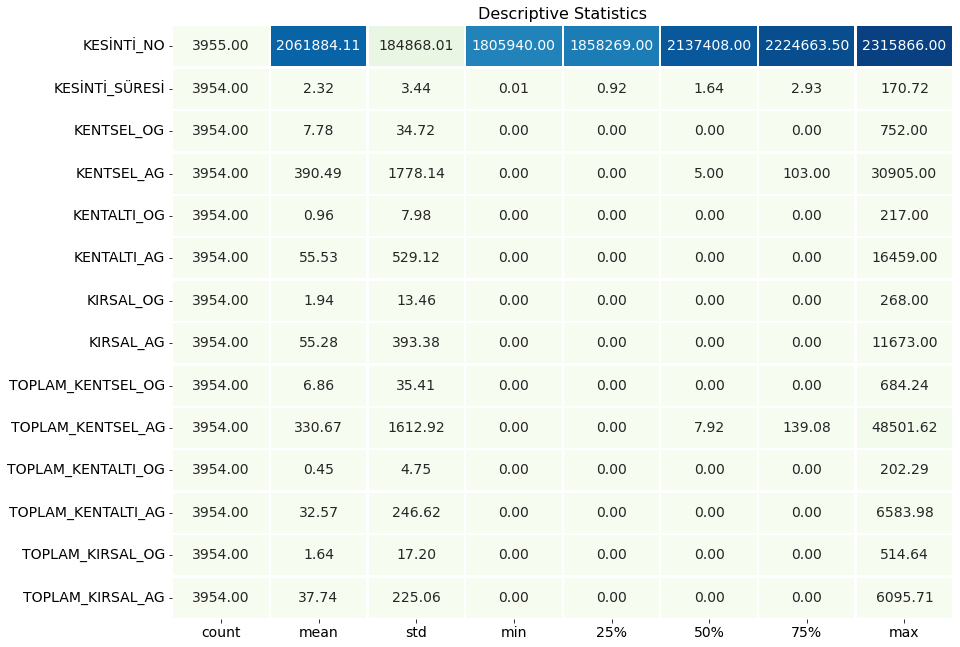

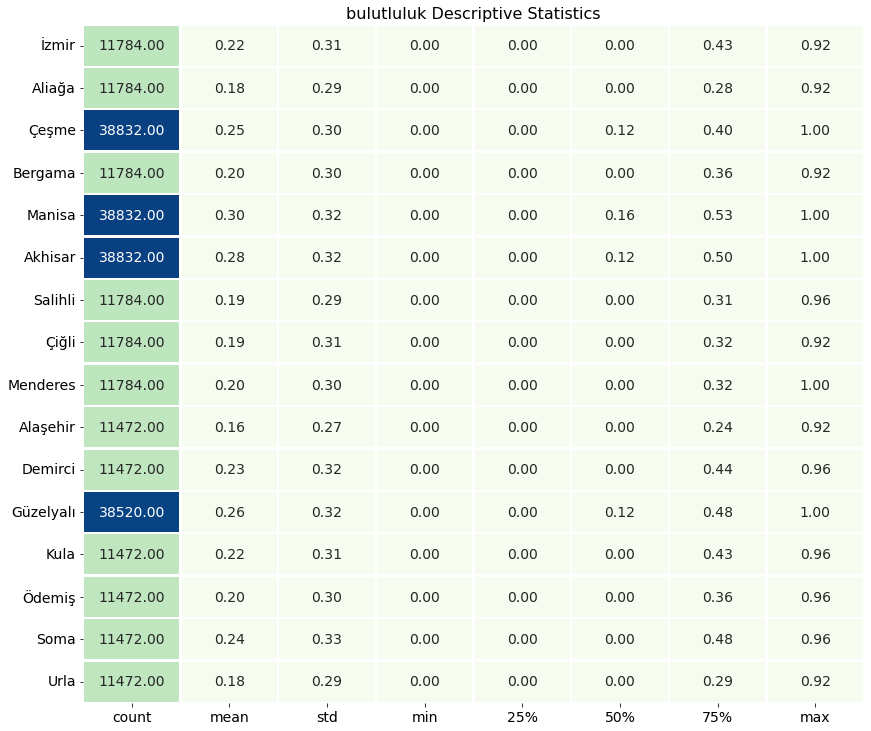

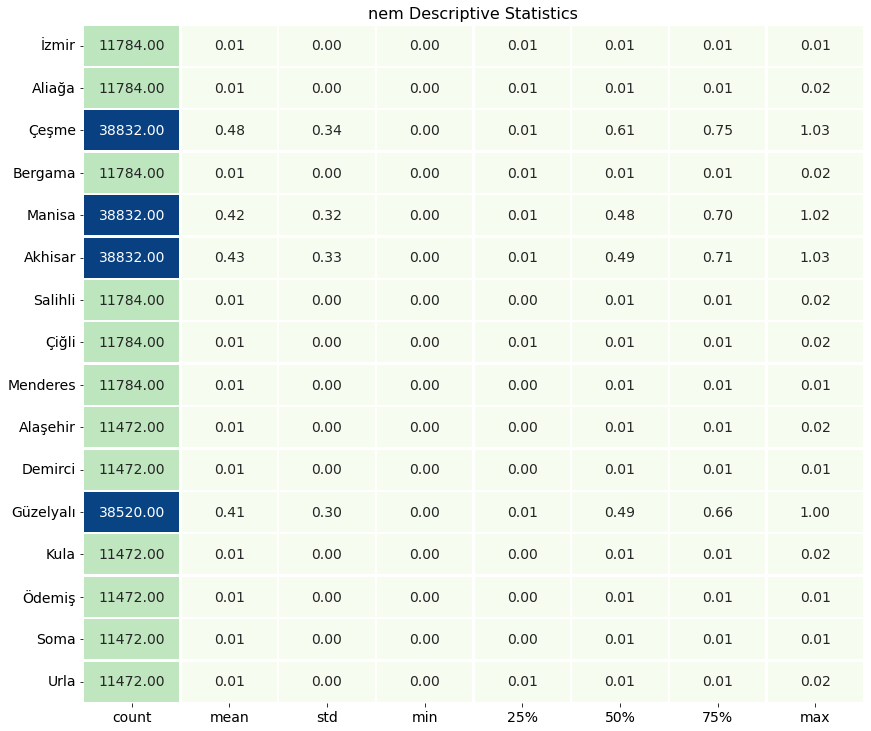

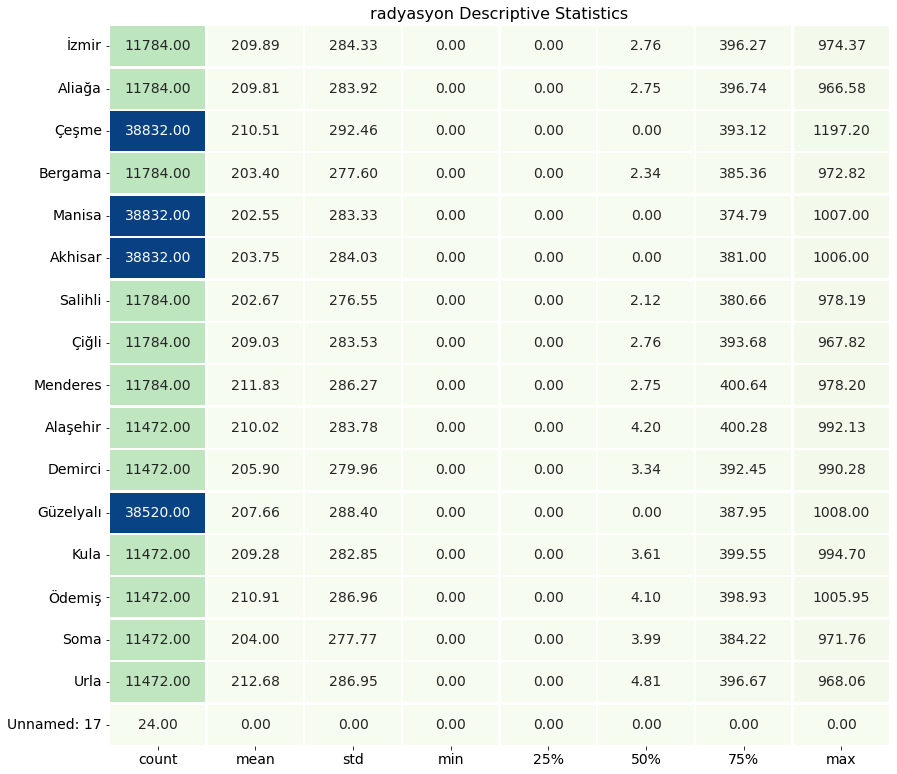

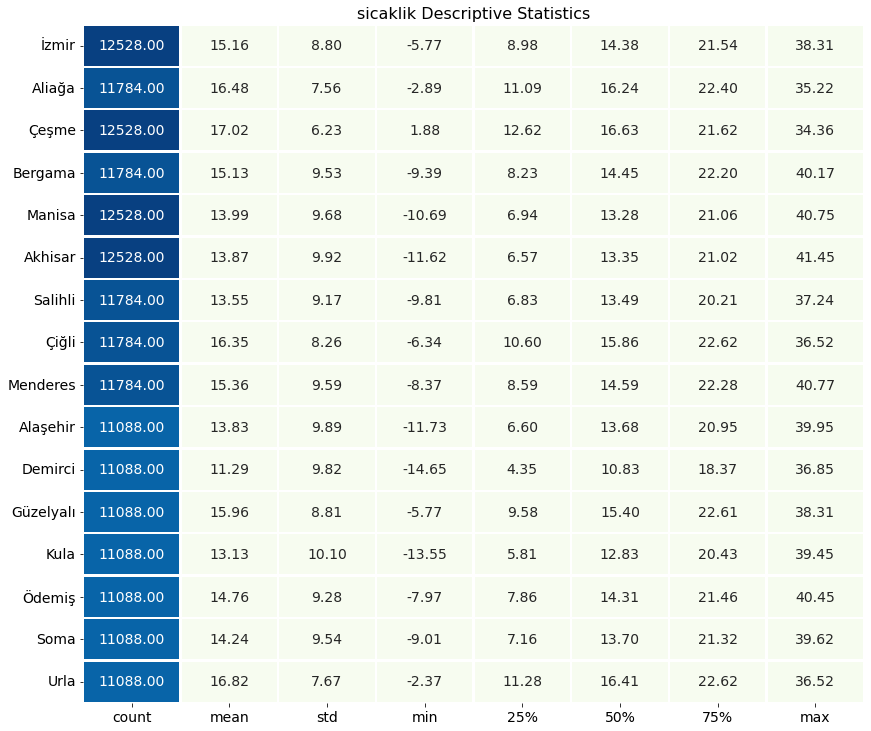

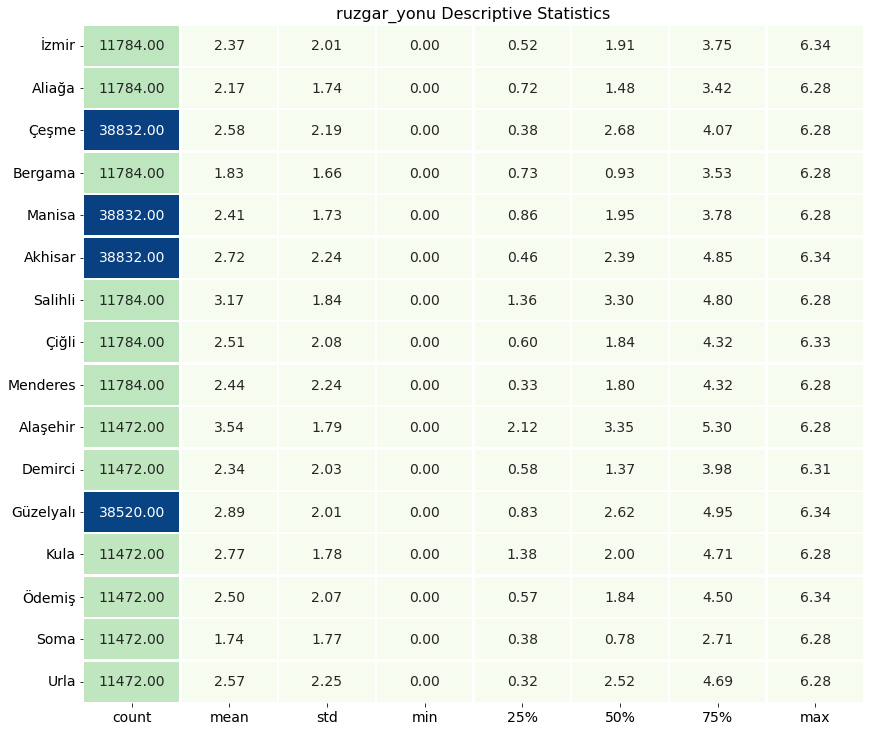

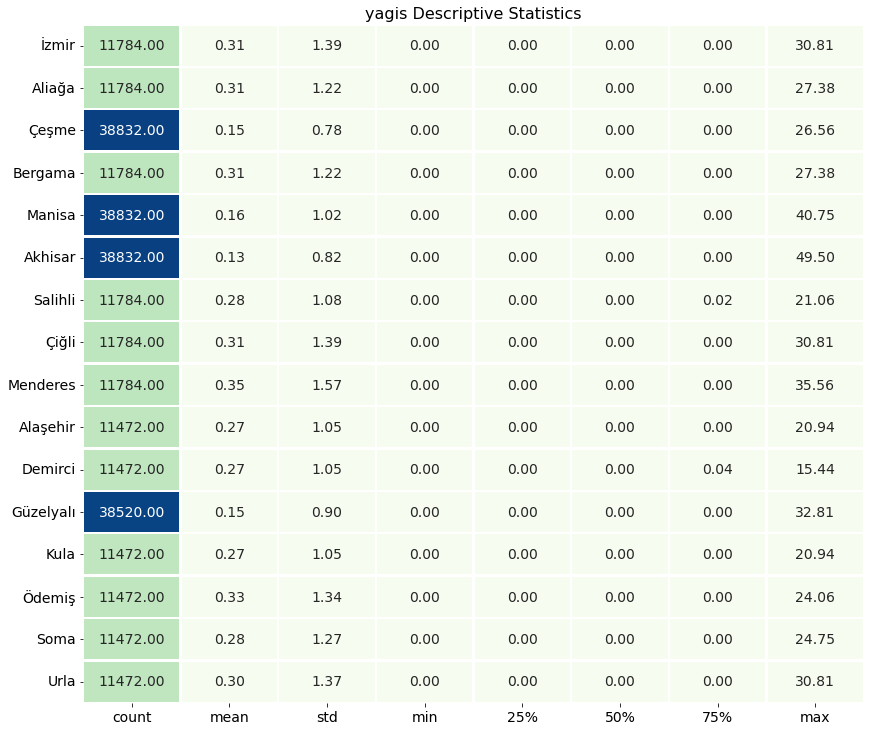

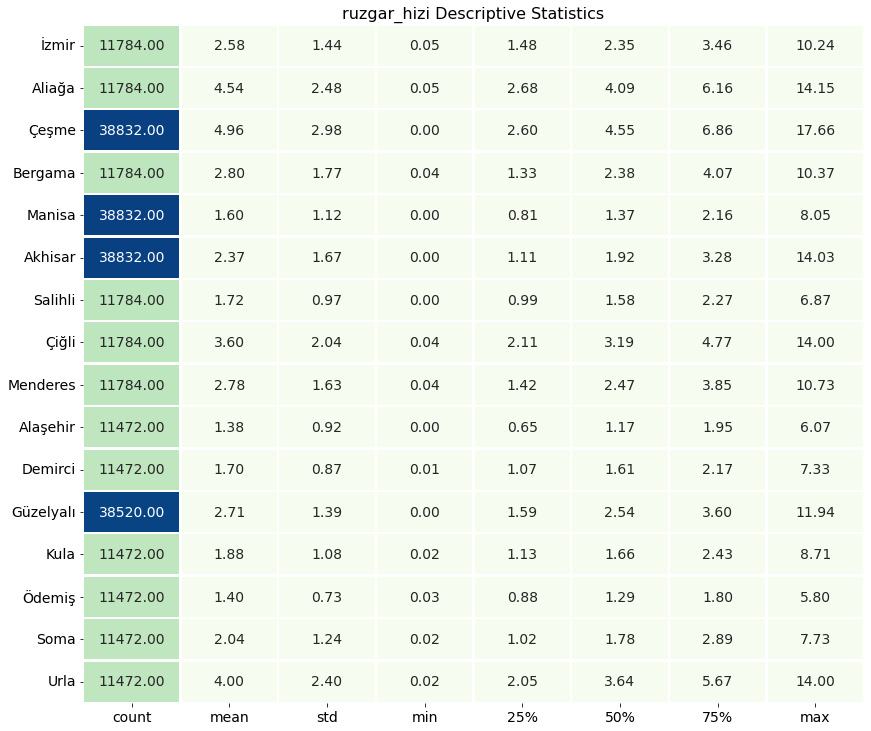

In [149]:
def desc_stats(dataframe, title = None):
    df_ = dataframe.select_dtypes(include = [float, int]).copy()
    desc = df_.describe().T
    f,ax = plt.subplots(figsize=(14,
                                 desc.shape[0]*0.78))
    sns.heatmap(desc,
                annot = True,
                cmap= cmap1,
                fmt= '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.35,
                cbar = False,
                annot_kws = {"size": 14})
    plt.xticks(size = 14)
    plt.yticks(size = 14,
               rotation = 0)
    if title == None:
        title = 'Descriptive Statistics'
    plt.title(title, size = 16)
    plt.show()

desc_stats(df)
for data in hava_durumu_datasets:
    title = [x for x in globals() if globals()[x] is data][0]
    desc_stats(data, title = f'{title} Descriptive Statistics')

# **Corr Analysis**

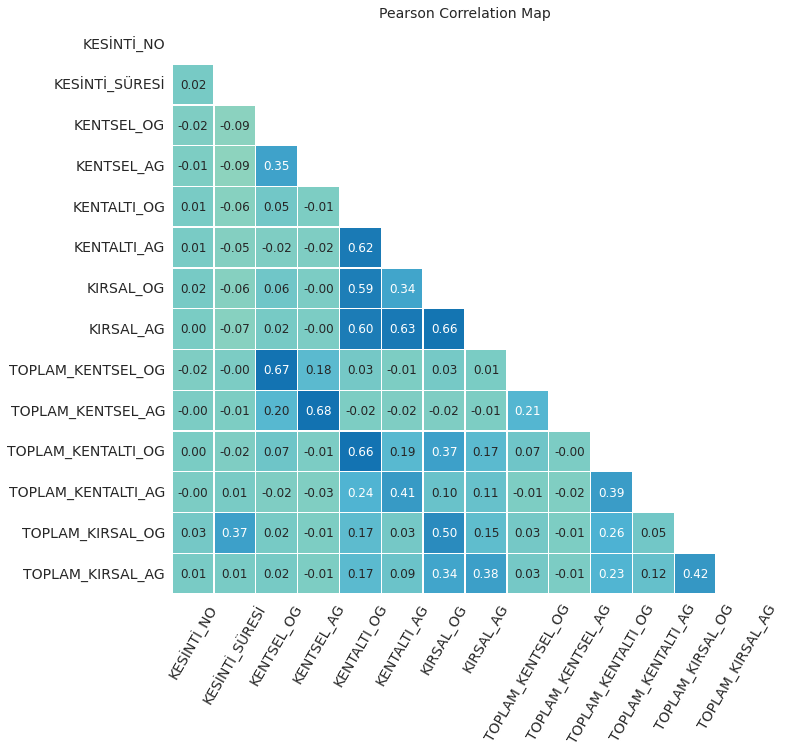

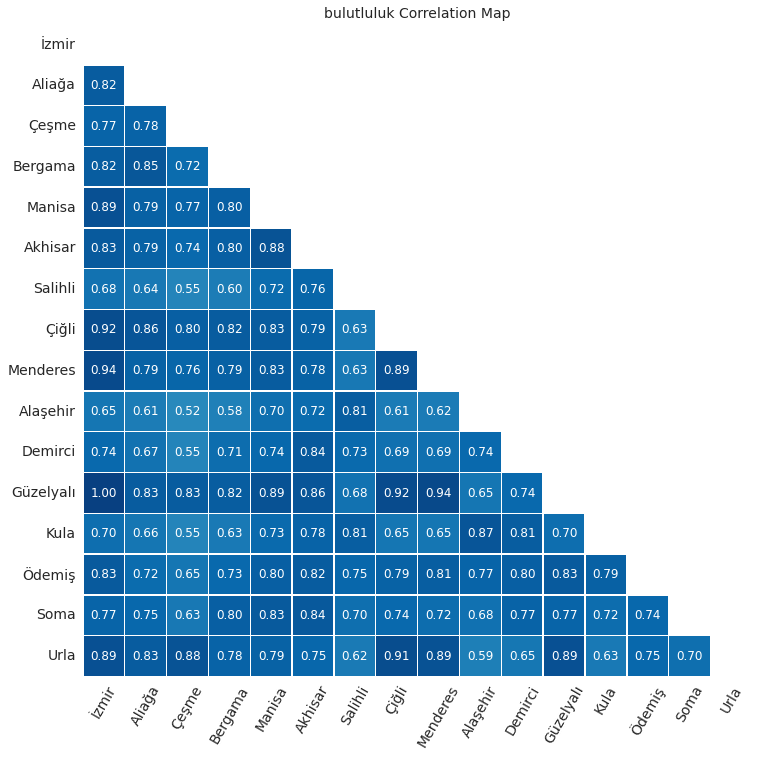

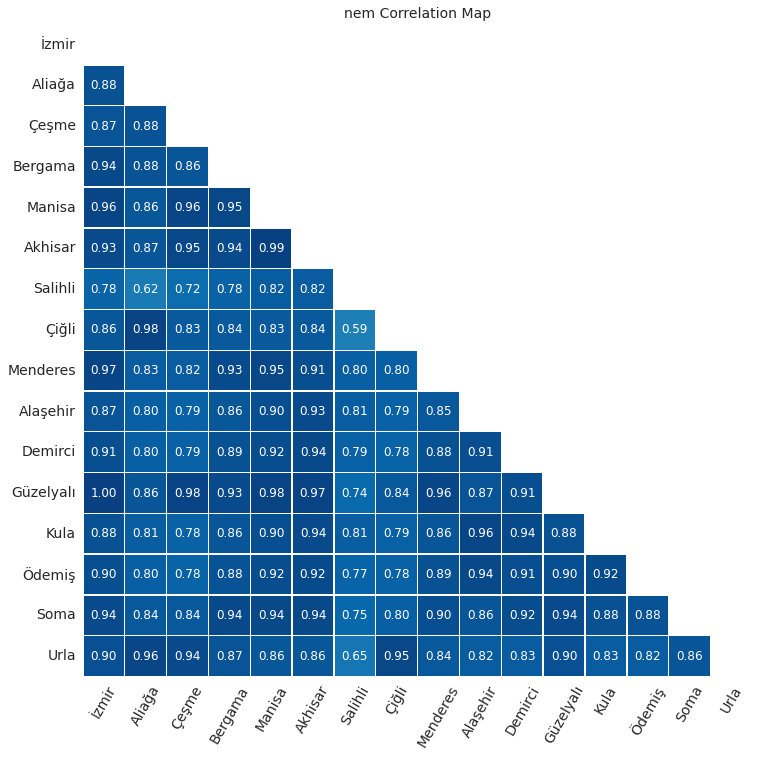

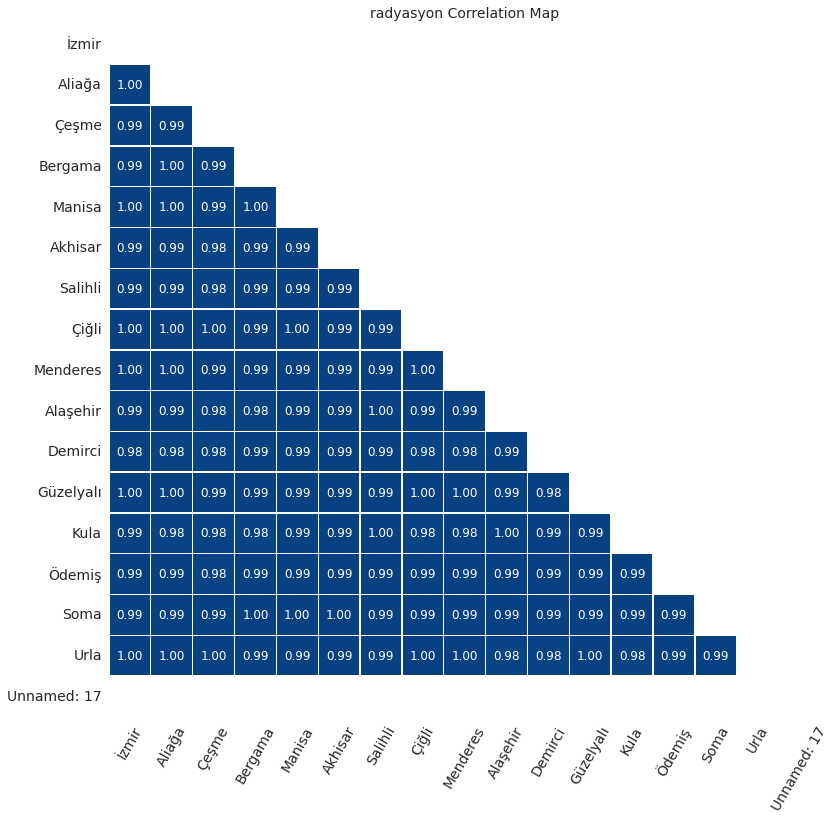

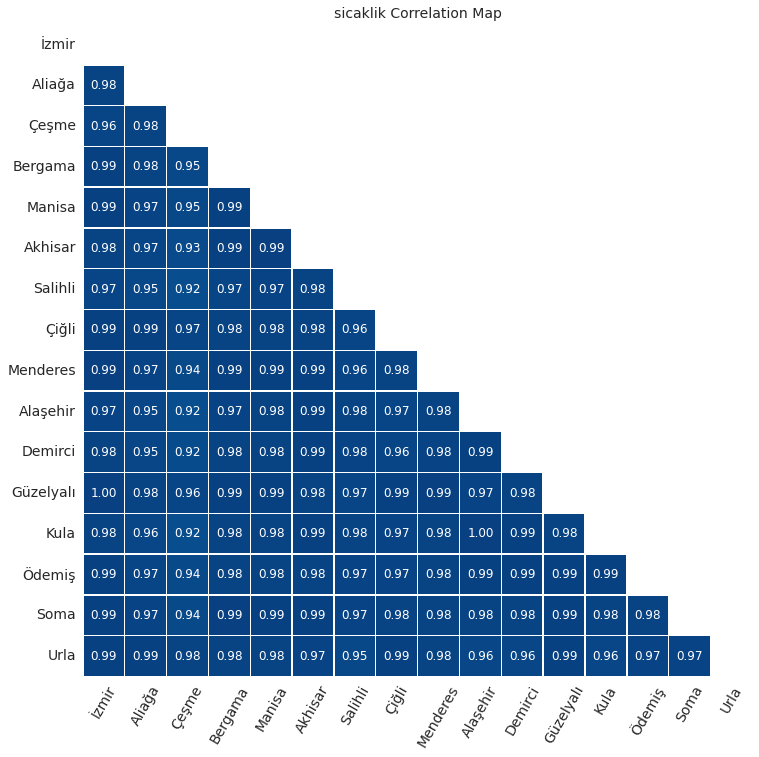

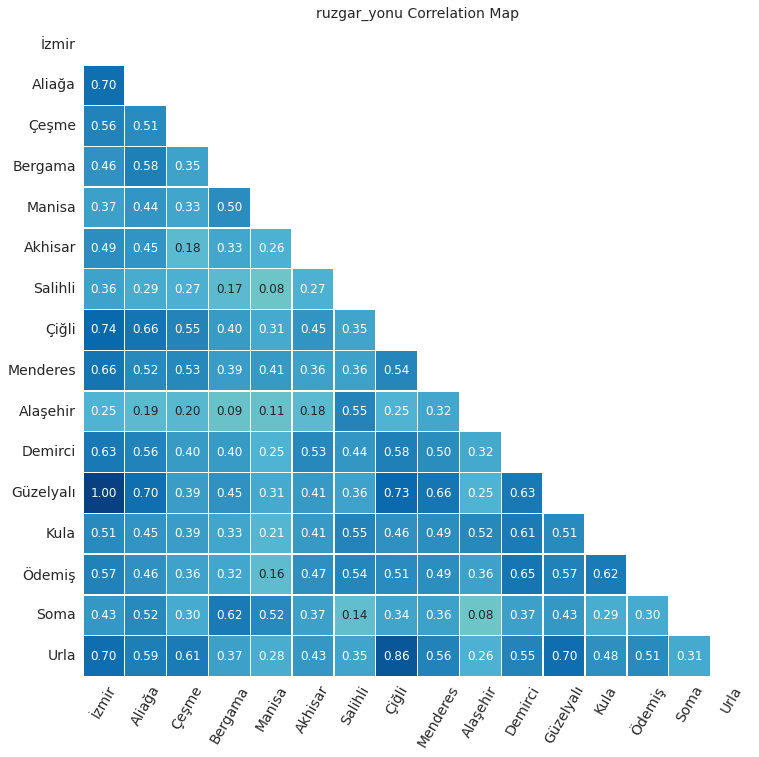

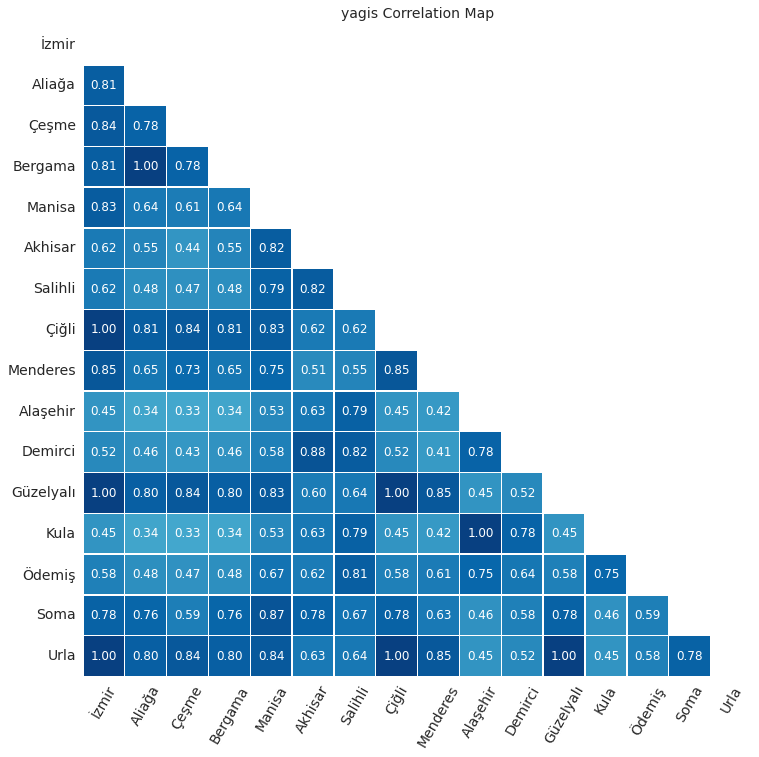

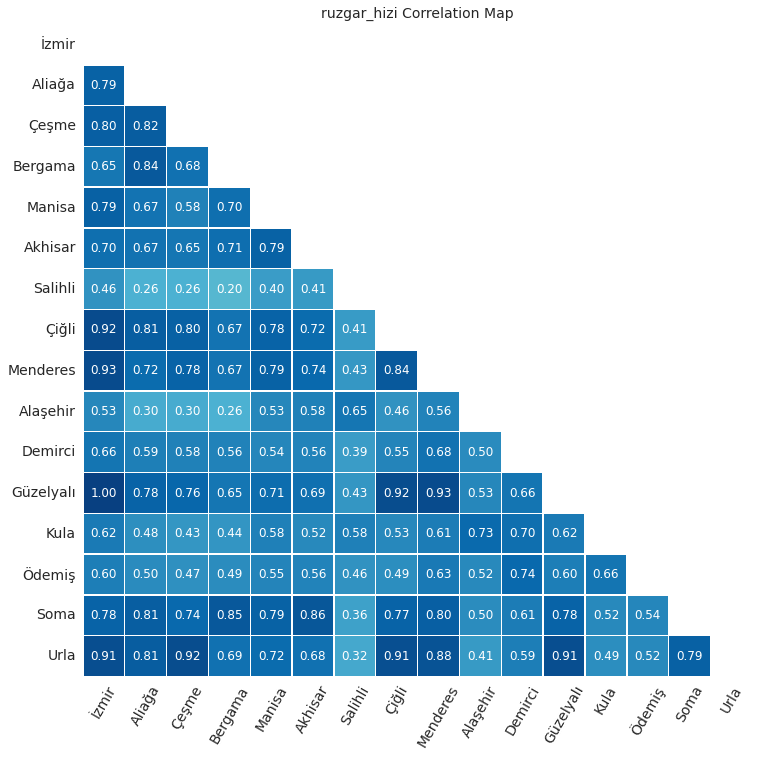

In [155]:
def corr_map(df, method = 'pearson', title = None):
    assert method in ['pearson', 'spearman'], 'Invalid Correlation Method'
    sns.set_style("white")
    matrix = np.triu(df.corr(method = method))
    f,ax=plt.subplots(figsize = (matrix.shape[0]*0.75,
                                 matrix.shape[1]*0.75))
    sns.heatmap(df.corr(method=method),
                annot= True,
                fmt = ".2f",
                cbar = False,
                ax=ax,
                vmin = -1,
                vmax = 1,
                mask = matrix,
                cmap = cmap1,
                linewidth = 0.4,
                linecolor = "white",
                annot_kws={"size": 12})
    plt.xticks(rotation = 60, size = 14)
    plt.yticks(rotation = 0, size = 14)
    if title == None:
        title = f'{method.title()} Correlation Map'
    plt.title(title, size = 14)
    plt.show()

corr_map(df)
for data in hava_durumu_datasets:
    title = [x for x in globals() if globals()[x] is data][0]
    corr_map(data, title = f'{title} Correlation Map')

# **Categorical Features Analysis**

*İL*

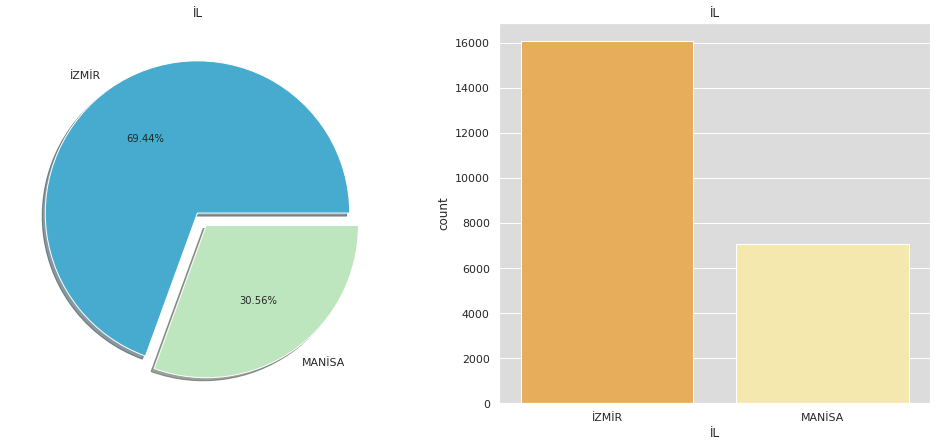

In [325]:
f,ax=plt.subplots(1,2,figsize=(17,7))
df['İL'].value_counts().plot.pie(explode=[0,0.1],autopct='%.2f%%',ax=ax[0],shadow=True, colors=['#47ABCF', '#BDE5BE'] )
ax[0].set_title('İL')
ax[0].set_ylabel('')
sns.countplot('İL',data=df,ax=ax[1],palette=['#FFB143',"#FFEFA4"])
ax[1].set_title('İL')
plt.show()

*İLÇE*

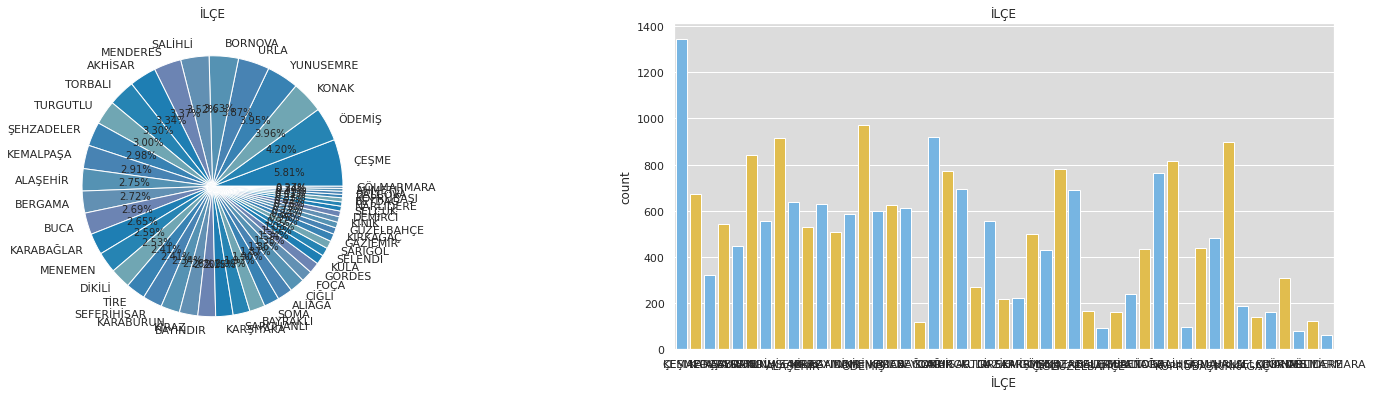

In [396]:
f,ax=plt.subplots(1,2,figsize=(26,6))
df['İLÇE'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0],shadow=False, colors=['#1E7EB3','#2684B3','#70A6B3','#3882B3','#4883B3','#5592B3','#6290B3','#6C84B3'])
ax[0].set_title('İLÇE')
ax[0].set_ylabel('')
sns.countplot('İLÇE',data=df,ax=ax[1],palette=['#65B8F4',"#FAC935"])
ax[1].set_title('İLÇE')
plt.show()

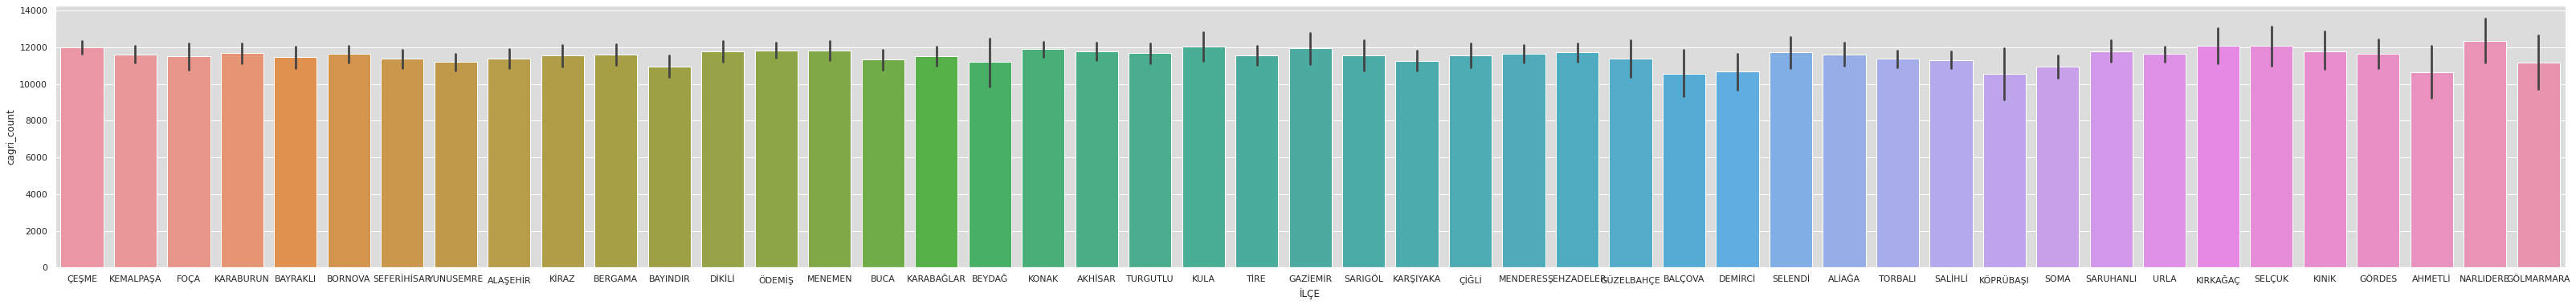

In [380]:
df['cagri_count'] = df.index

fig, ax = plt.subplots(figsize=(56,6))

sns.set_color_codes("bright")
sns.barplot(x="İLÇE", y="cagri_count", data=df)


*Şebeke Unsuru*

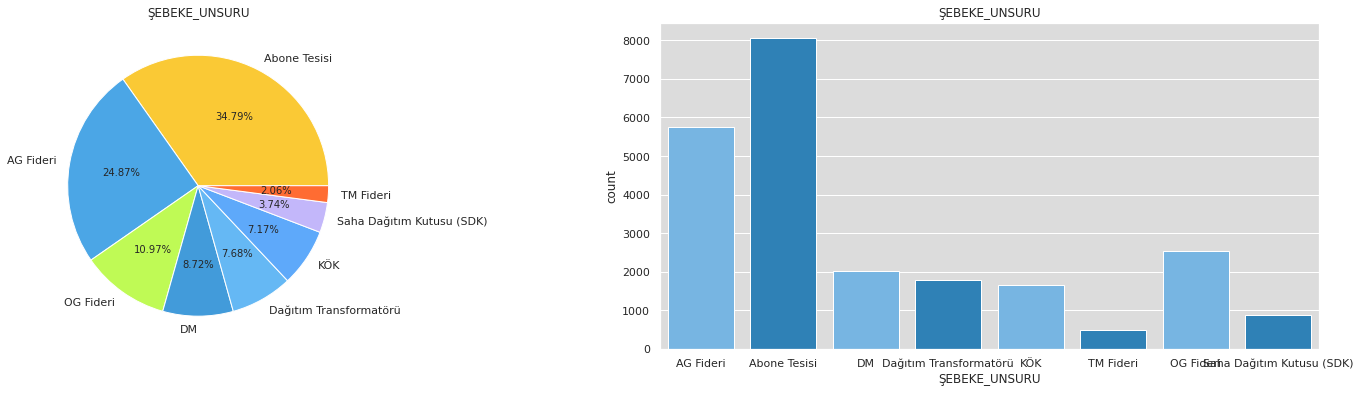

In [395]:
f,ax=plt.subplots(1,2,figsize=(26,6))
df['ŞEBEKE_UNSURU'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0],shadow=False, colors=['#FAC935','#4BA6E6','#BFFA55','#429BDA','#65B8F4','#5EA9FA','#C3B7FA','#FF6C32'])
ax[0].set_title('ŞEBEKE_UNSURU')
ax[0].set_ylabel('')
sns.countplot('ŞEBEKE_UNSURU',data=df,ax=ax[1],palette=['#65B8F4',"#1886CC"])
ax[1].set_title('ŞEBEKE_UNSURU')
plt.show()

*Kesinti Nedenine İlişkin Açıklama*

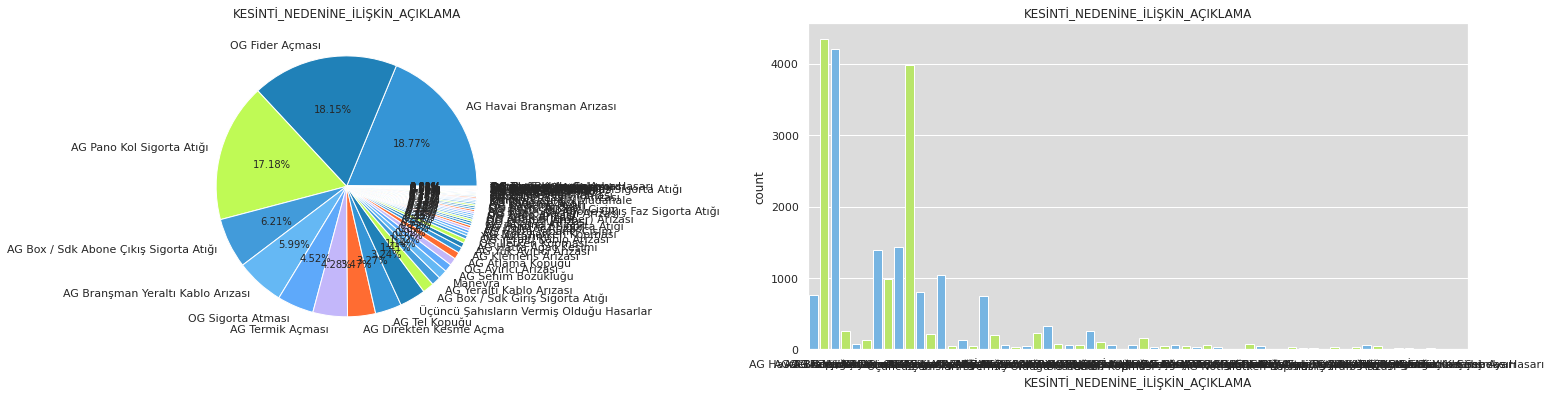

In [410]:
f,ax=plt.subplots(1,2,figsize=(26,6))
df['KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0],shadow=False, colors=['#3595D6','#2081B8','#BFFA55','#429BDA','#65B8F4','#5EA9FA','#C3B7FA','#FF6C32'])
ax[0].set_title('KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA')
ax[0].set_ylabel('')
sns.countplot('KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA',data=df,ax=ax[1],palette=['#65B8F4',"#BFFA55"])
ax[1].set_title('KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA')
plt.show()

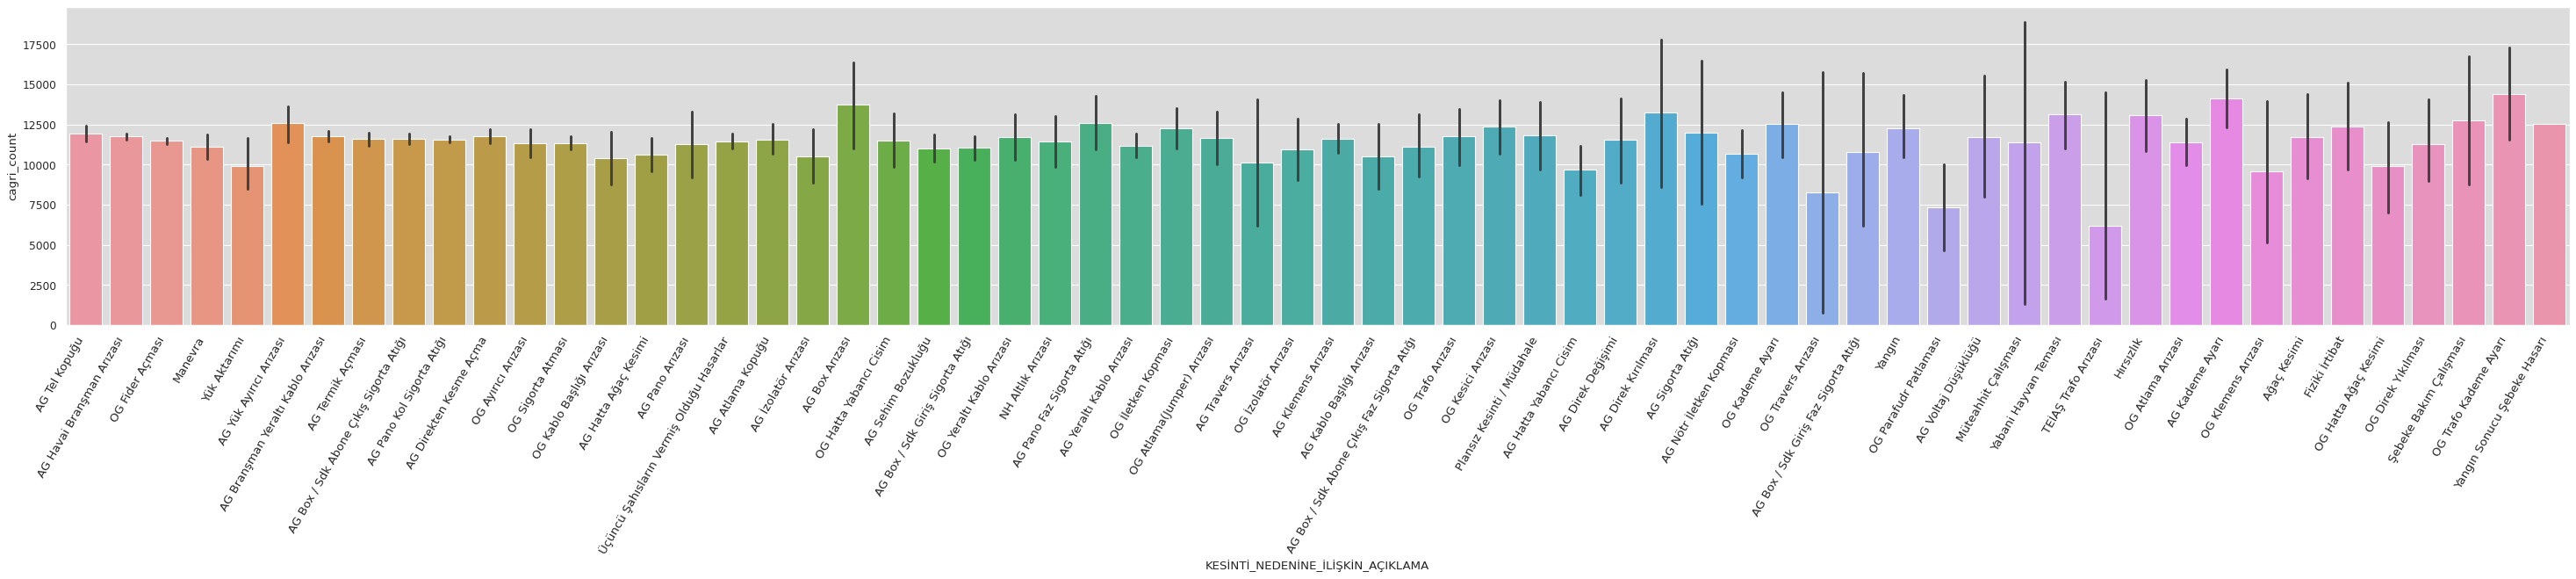

In [411]:
df['cagri_count'] = df.index

fig, ax = plt.subplots(figsize=(46,6),facecolor='white', dpi= 80, linewidth=20)
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)



sns.set_color_codes("bright")
sns.barplot(x="KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA", y="cagri_count", data=df)

*Kaynağa Göre*

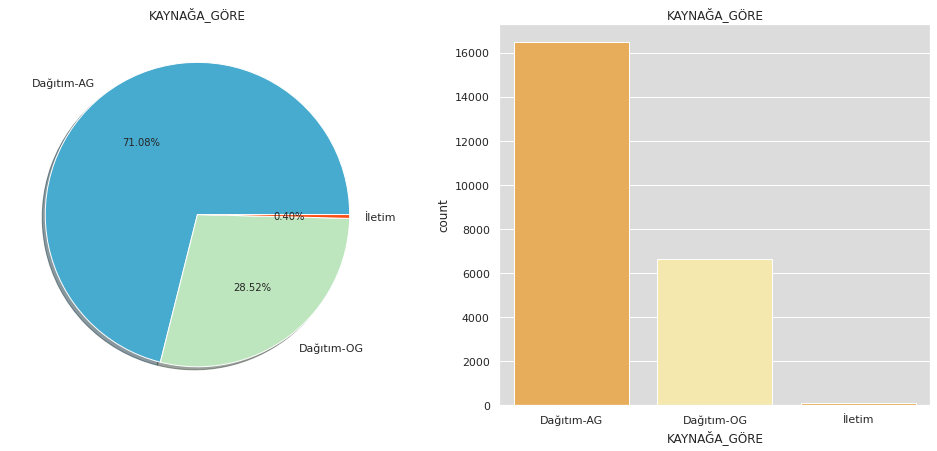

In [414]:
f,ax=plt.subplots(1,2,figsize=(17,7))
df['KAYNAĞA_GÖRE'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0],shadow=True, colors=['#47ABCF', '#BDE5BE','#FA4F14'] )
ax[0].set_title('KAYNAĞA_GÖRE')
ax[0].set_ylabel('')
sns.countplot('KAYNAĞA_GÖRE',data=df,ax=ax[1],palette=['#FFB143',"#FFEFA4"])
ax[1].set_title('KAYNAĞA_GÖRE')
plt.show()

*Süreye Göre*

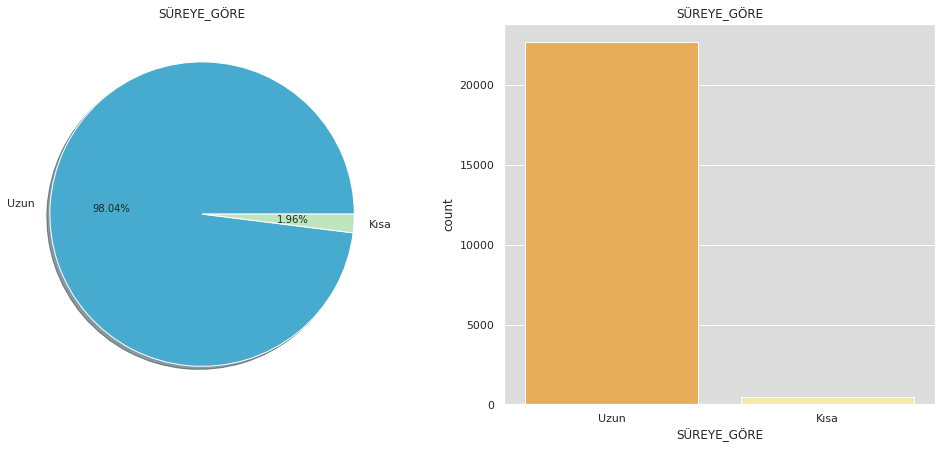

In [415]:
f,ax=plt.subplots(1,2,figsize=(17,7))
df['SÜREYE_GÖRE'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0],shadow=True, colors=['#47ABCF', '#BDE5BE','#FA4F14'] )
ax[0].set_title('SÜREYE_GÖRE')
ax[0].set_ylabel('')
sns.countplot('SÜREYE_GÖRE',data=df,ax=ax[1],palette=['#FFB143',"#FFEFA4"])
ax[1].set_title('SÜREYE_GÖRE')
plt.show()

*Sebebe Göre*

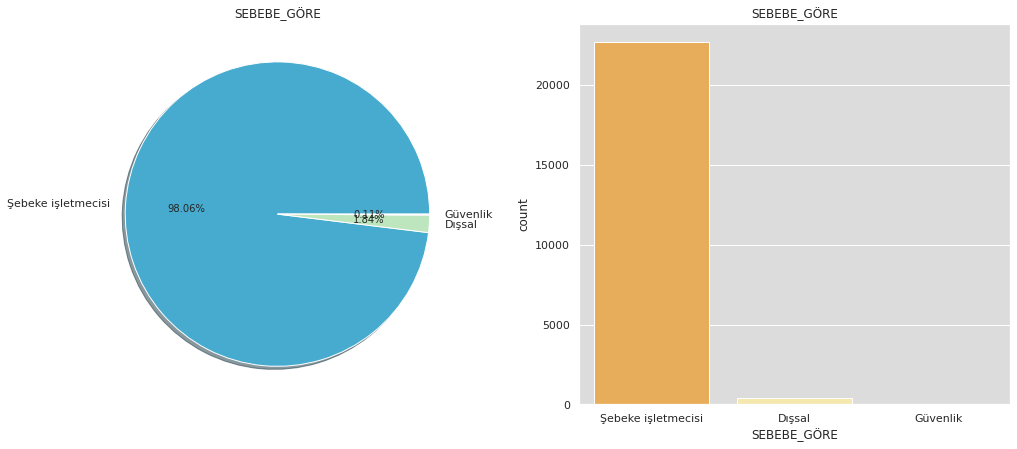

In [416]:
f,ax=plt.subplots(1,2,figsize=(17,7))
df['SEBEBE_GÖRE'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0],shadow=True, colors=['#47ABCF', '#BDE5BE','#FA4F14'] )
ax[0].set_title('SEBEBE_GÖRE')
ax[0].set_ylabel('')
sns.countplot('SEBEBE_GÖRE',data=df,ax=ax[1],palette=['#FFB143',"#FFEFA4"])
ax[1].set_title('SEBEBE_GÖRE')
plt.show()

# **Numerical Features Analysis**

In [428]:
def date_analyser(df, date_col):
    df_ = df.copy()
    df_['date'] = df_[date_col].dt.date
    df_grouped = df_.groupby('date').size(). \
    to_frame('count').reset_index().sort_values('date')
    data = go.Scatter(x = df_grouped['date'],
                      y = df_grouped['count'],
                      mode = 'lines',
                      name = 'Number of Power Outages',
                      marker = dict(color = 'orange'))
    layout = go.Layout(title={'text': "Number of Power Outages by Dates",
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = 'Date'),
                       yaxis = dict(title = 'Power Outages'),
                       template = 'plotly_white')
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)

date_analyser(train, 'BAŞLAMA_TARİHİ_VE_ZAMANI')

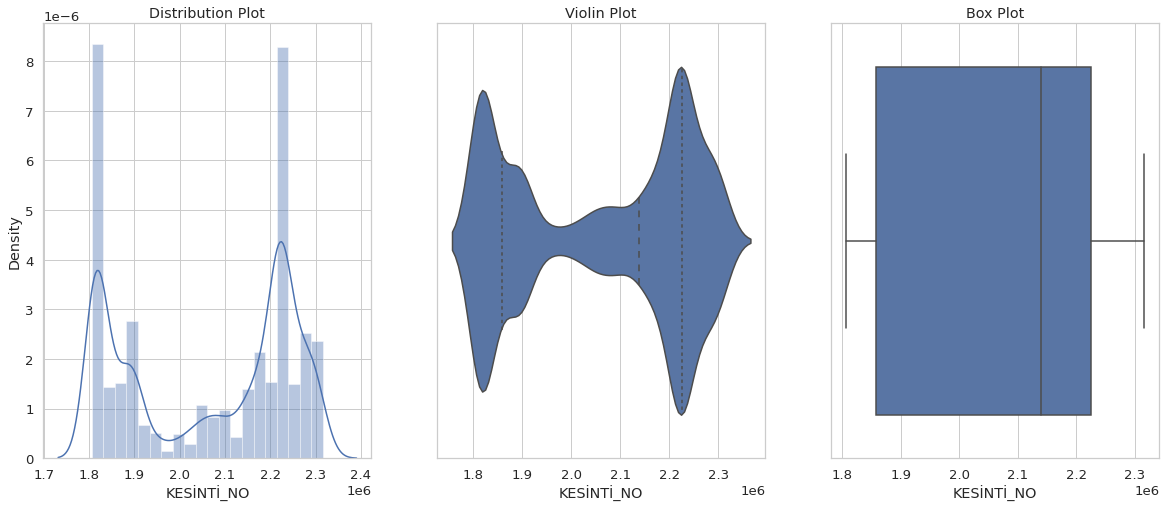

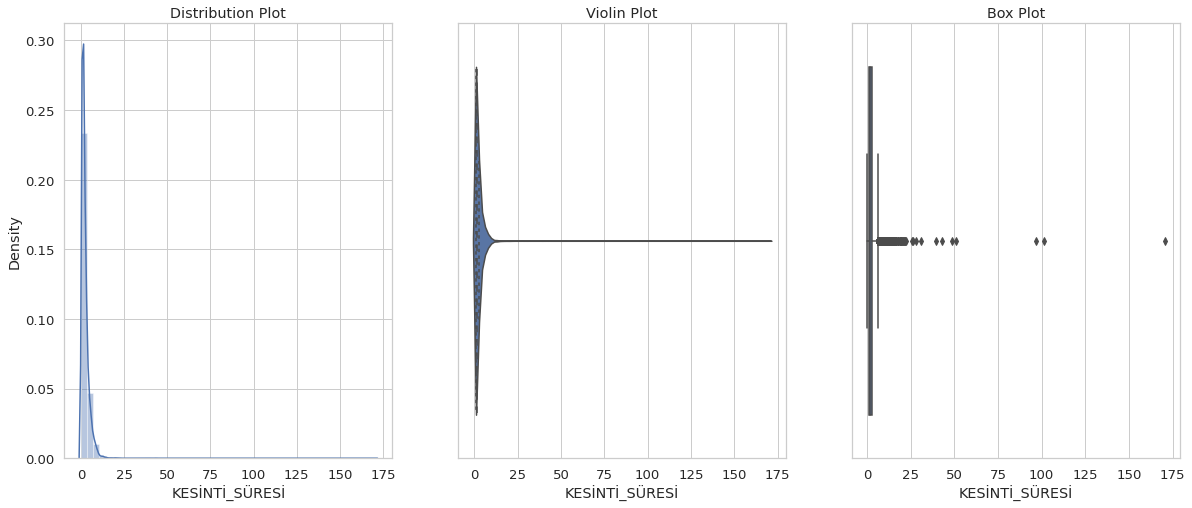

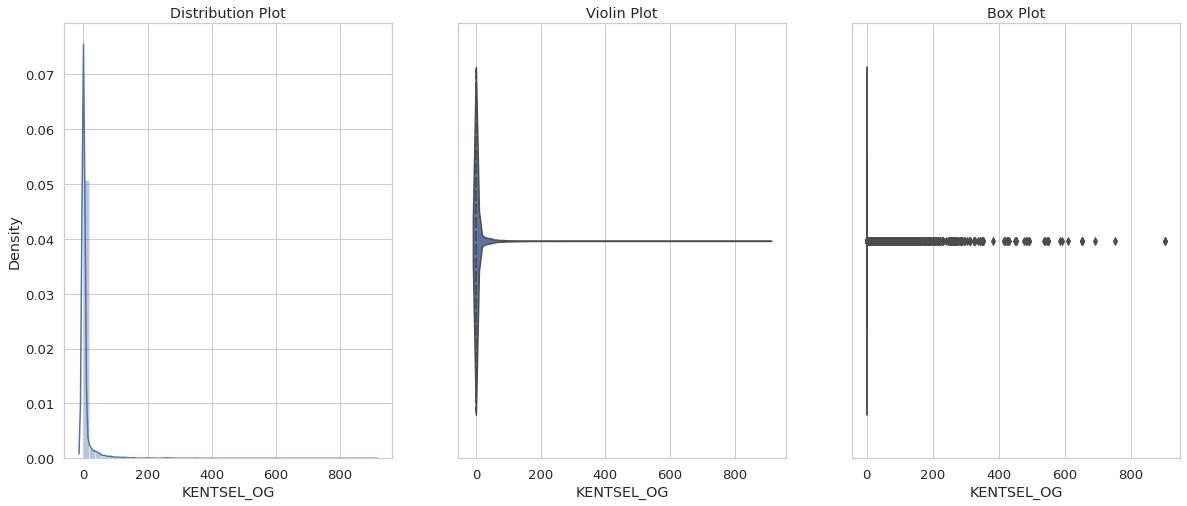

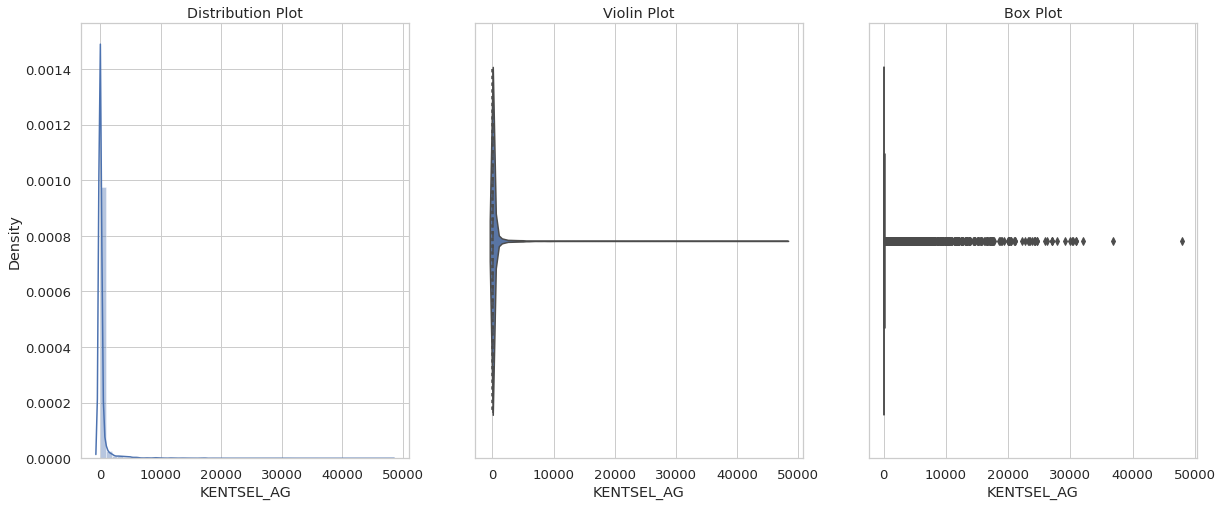

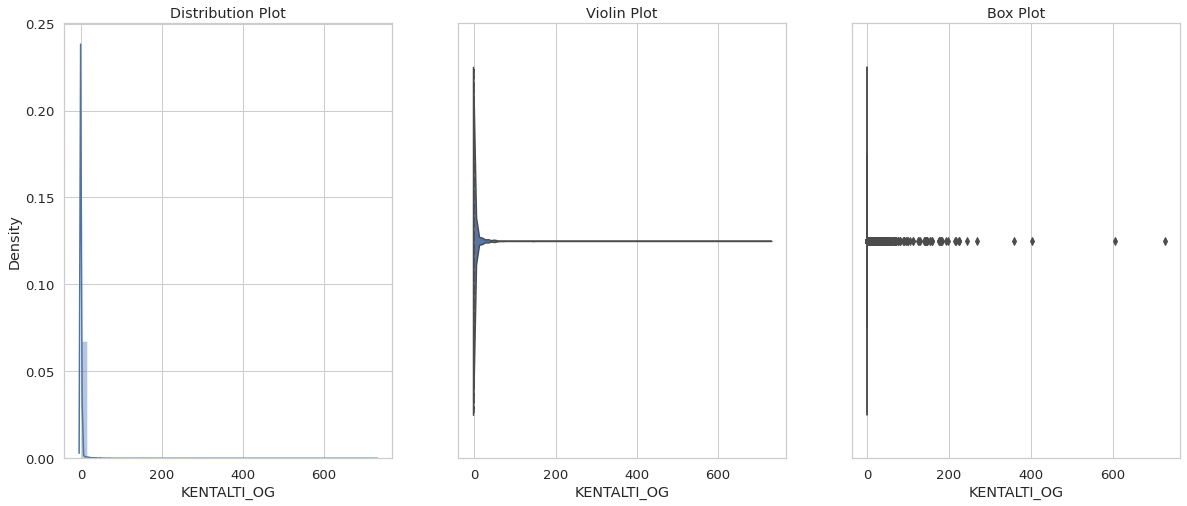

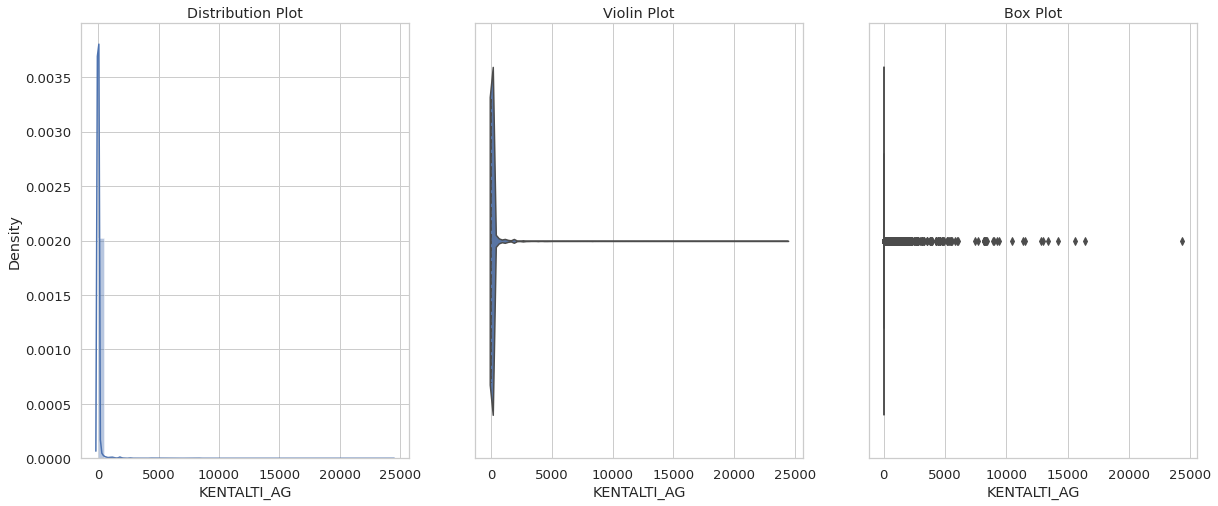

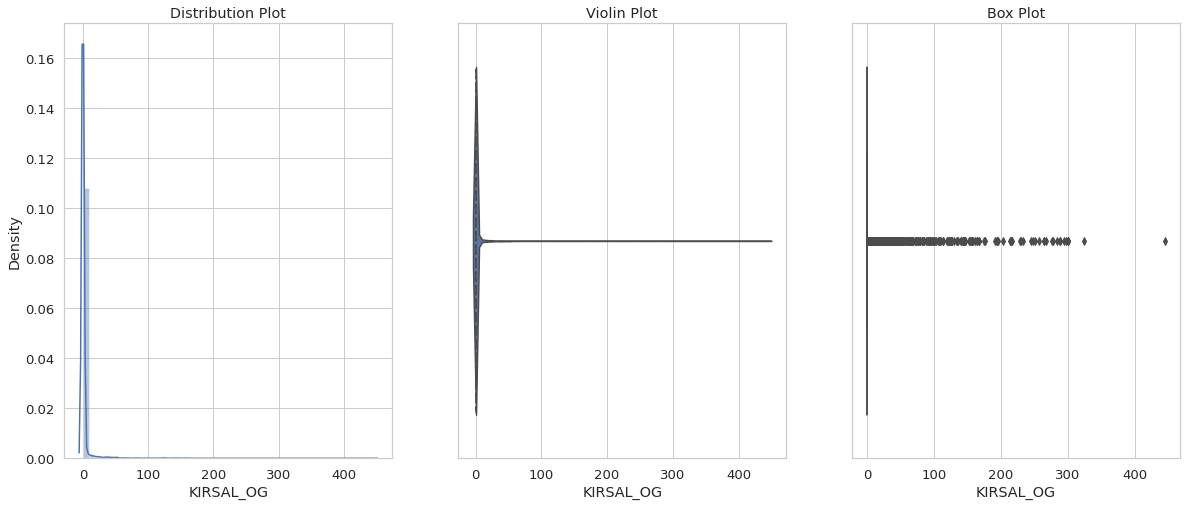

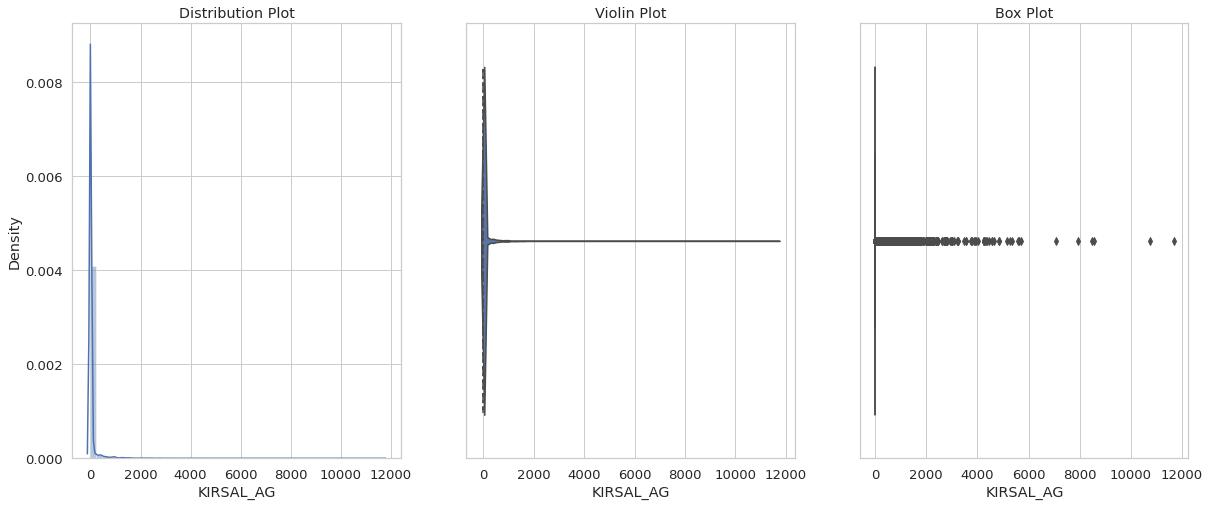

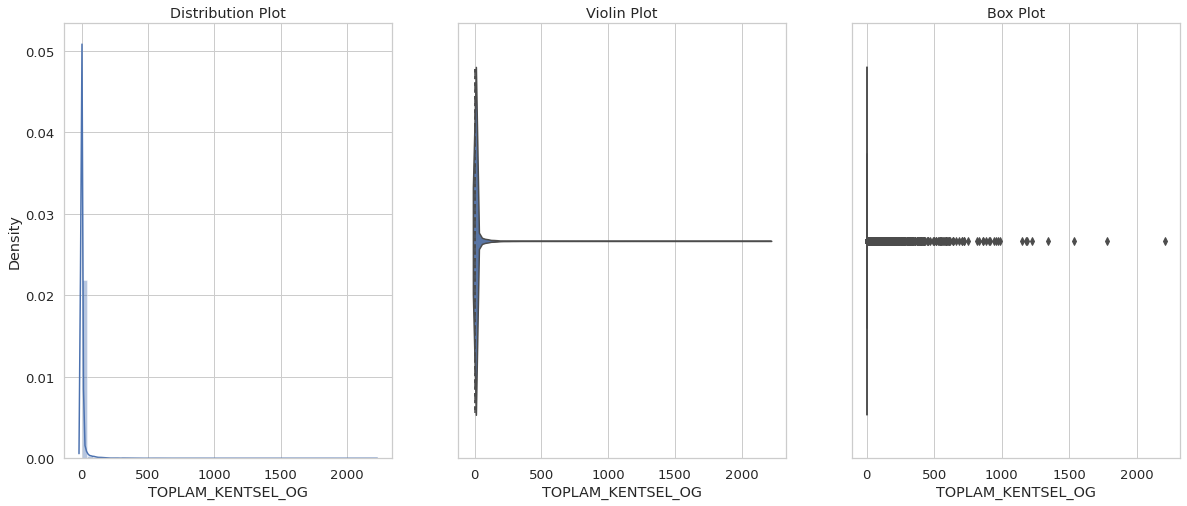

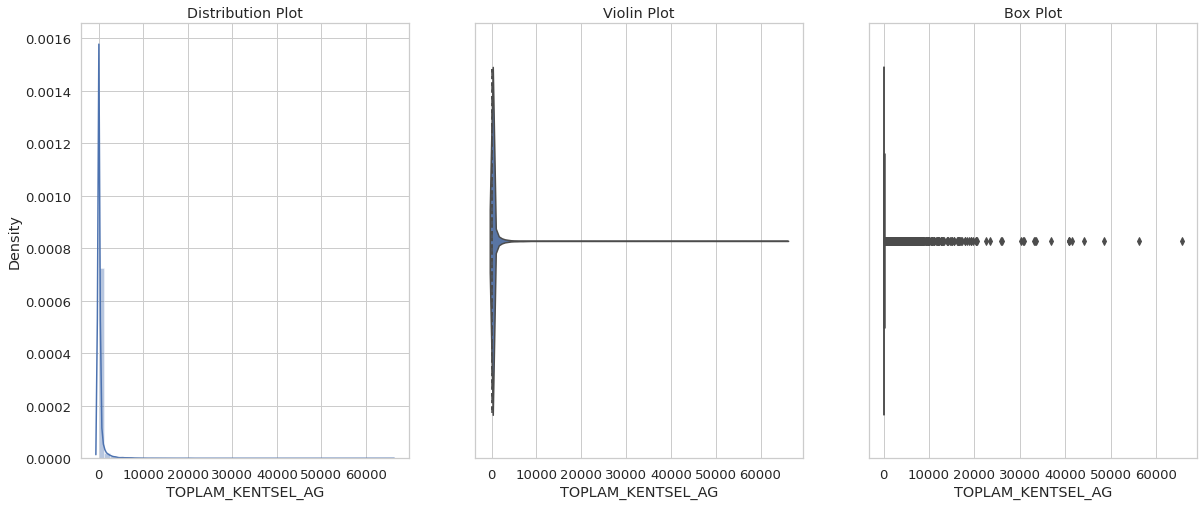

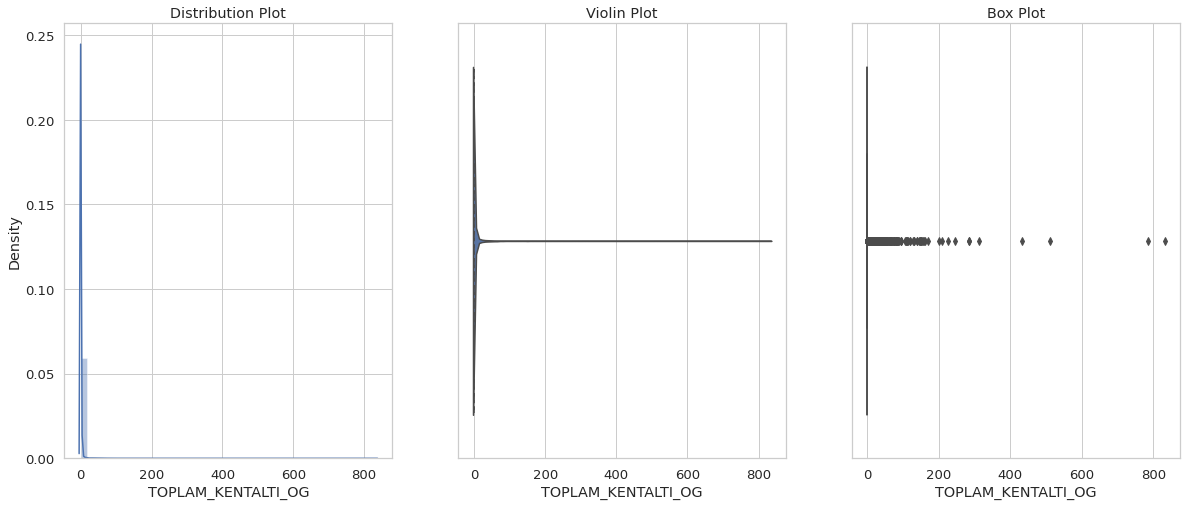

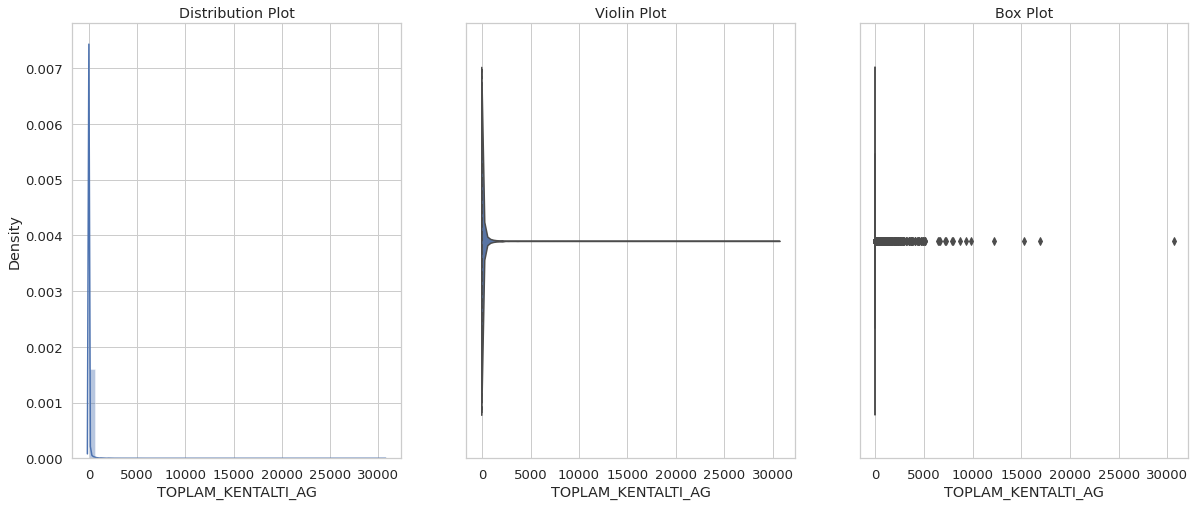

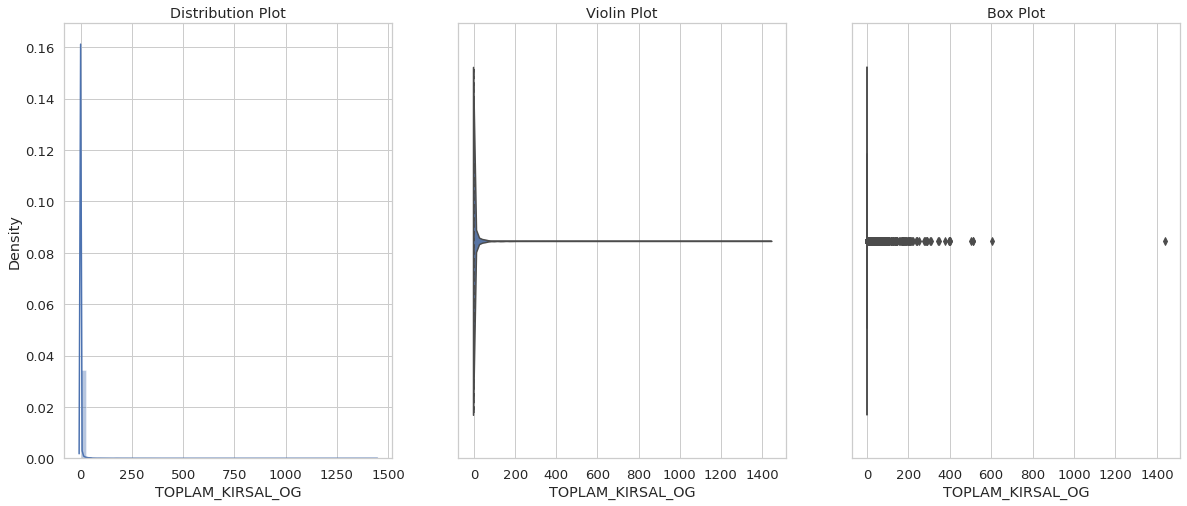

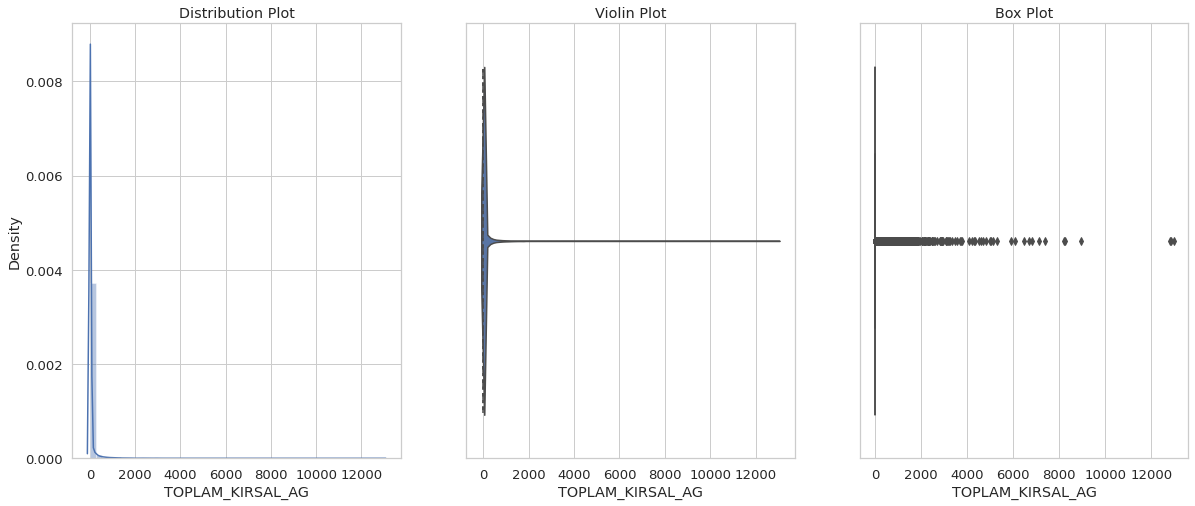

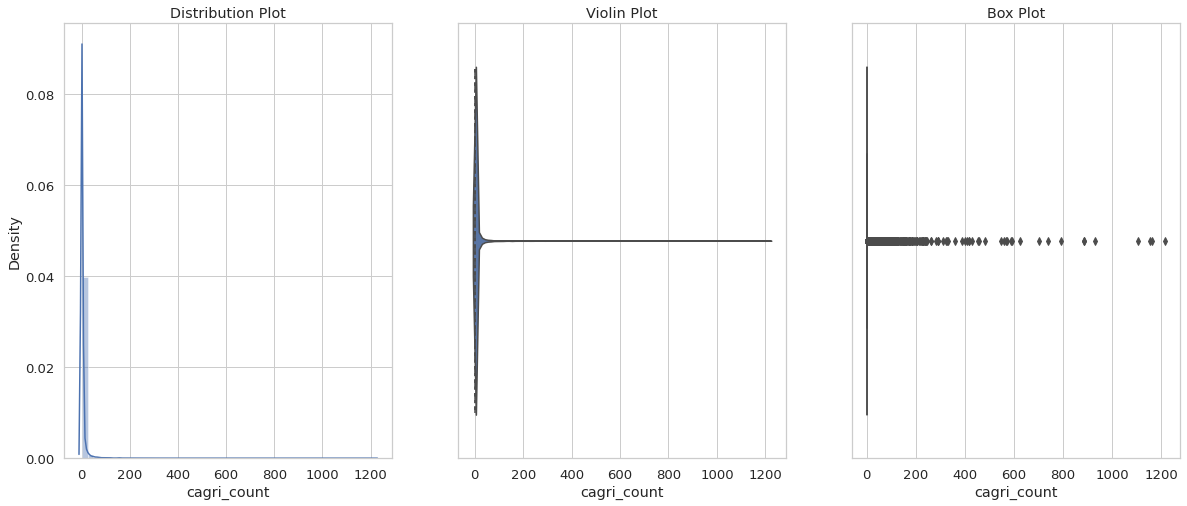

In [448]:


def univariate(df,col,vartype,hue =None):    
    '''
    Univariate function will plot parameter values in graphs.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuous or categorical
                Continuous(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : Only applicable in categorical analysis.
    '''

    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
    plt.show()
    
for col in num_cols:
    univariate(train,col,vartype=0)